In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import gc
import mne
from scipy.stats import zscore
from scipy.signal import detrend
import copy
np.set_printoptions(threshold=100)  # Default threshold
mne.set_log_level('WARNING')
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

#this can run all of the pairs in ~ 
run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0,20)
classes_right = np.arange(0,20)

def preprocess(data):
    # data = detrend(data, axis=0)
    # epsilon = 1e-9
    # data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
    return data

agg_structure = {f'dataset_{file_number}': 
                 {f'left_class_{class_left}': 
                  {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

left_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
right_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
attention_LFP_attleft_agg = copy.deepcopy(agg_structure)

left_input_LFP_attright_agg = copy.deepcopy(agg_structure)
right_input_LFP_attright_agg = copy.deepcopy(agg_structure)
attention_LFP_attright_agg = copy.deepcopy(agg_structure)

n_values = {f'dataset_{file_number}':
            {f'left_class_{class_left}':
             {f'right_class_{class_right}': {
                'attleft': [],
                'attright': []
                } for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

total_time = time.time()
total_load_time = time.time()
for file_number in file_numbers:   #will first load the file and extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")
    file_process_time = time.time()

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]
    relevant = np.where(omitted == 0)[0]    #indices of agg where not omitted
    
    left_input_LFP = preprocess(data['LFP'][0][0][relevant])
    right_input_LFP = preprocess(data['LFP'][0][1][relevant])
    attention_LFP = preprocess(data['LFP_rec'][0][2][relevant])

    for class_left in classes_left:
         for class_right in classes_right: 
    
            left_indices_agg = np.where((omitted ==0) & (attend_01 == 0) & (label_left == class_left) & (label_right == class_right))[0]
            left_indices = np.where(np.isin(relevant, left_indices_agg))[0]
            right_indices_agg = np.where((omitted ==0) & (attend_01 == 1) & (label_left == class_left) & (label_right == class_right))[0]
            right_indices = np.where(np.isin(relevant, right_indices_agg))[0]

            print(left_indices)
            print(right_indices)

            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attright'] = [len(right_indices)]  #nb need both left and right indices to be non empty

            if len(left_indices) >= 1:
                left_input_LFP_attleft = left_input_LFP[left_indices][:, 100:350]
                right_input_LFP_attleft = right_input_LFP[left_indices][:, 100:350]
                attention_LFP_attleft = attention_LFP[left_indices][:, 100:350]

                left_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_input_LFP_attleft)
                right_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_input_LFP_attleft)
                attention_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_LFP_attleft)
                print(f'appended {len(left_indices)} trial(s) to left_agg datasets')

            if len(right_indices) >= 1:

                left_input_LFP_attright = left_input_LFP[right_indices][:, 100:350]
                right_input_LFP_attright = right_input_LFP[right_indices][:, 100:350]
                attention_LFP_attright = attention_LFP[right_indices][:, 100:350]

                left_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_input_LFP_attright)   
                right_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_input_LFP_attright)
                attention_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_LFP_attright)
                print(f'appended {len(right_indices)} trial(s) to right_agg datasets')

    del data
    gc.collect()
    elapsed_time = time.time() - file_process_time
    print(f"Dataset {file_number} processed in {elapsed_time:.2f} seconds")


# for file_number in file_numbers:
#     if left_input_LFP_attleft_agg[f'dataset_{file_number}']['left_class_12']['right_class_18']:
#         print(f"Dataset {file_number} has {len(left_input_LFP_attleft_agg[f'dataset_{file_number}']['left_class_12']['right_class_18'][0])} trials for left attleft")

# for file_number in file_numbers:
#     if left_input_LFP_attright_agg[f'dataset_{file_number}']['left_class_12']['right_class_18']:
#         print(f"Dataset {file_number} has {len(left_input_LFP_attright_agg[f'dataset_{file_number}']['left_class_12']['right_class_18'][0])} trials for left attright")

# for file_number in file_numbers:
#     print(f'n_values left for dataset {file_number} = {n_values[f"dataset_{file_number}"]["left_class_12"]["right_class_18"]["attleft"]}')

# for file_number in file_numbers:    
#     print(f'n_values right for dataset {file_number} = {n_values[f"dataset_{file_number}"]["left_class_12"]["right_class_18"]["attright"]}')


#dont want to process here - want to process when its in the big array
print(f'Total load time = {time.time() - total_load_time:.2f} seconds')

#-------formatting the trials into a single array for each class pair, of length n_samples * n_trials------------------
all_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left}

left_attleft = copy.deepcopy(all_structure)
right_attleft = copy.deepcopy(all_structure)
att_attleft = copy.deepcopy(all_structure)

left_attright = copy.deepcopy(all_structure)
right_attright = copy.deepcopy(all_structure)
att_attright = copy.deepcopy(all_structure)


for filenumber in file_numbers:
    for class_left in classes_left:
        for class_right in classes_right:
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])


for class_left in classes_left:
        for class_right in classes_right:
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])


n_values_sum = {f'left_class_{class_left}': {f'right_class_{class_right}': {'attleft': 0, 'attright': 0} for class_right in classes_right} for class_left in classes_left}


for class_left in classes_left:
    for class_right in classes_right:
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'][0] for dataset in file_numbers  #this will check through all the datasets 
        )
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attright'][0] for dataset in file_numbers
        )

#this should now pick a class pair, and just sum the number in the dataset for each attention condition

# print('total number of trials in left attleft =', n_values_sum['left_class_12']['right_class_18']['attleft'])
# print('total number of trials in left attright =', n_values_sum['left_class_12']['right_class_18']['attright'])



c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


Dataset 1 loaded in 15.92 seconds
[]
[828 872]
appended 2 trial(s) to right_agg datasets
[791]
[]
appended 1 trial(s) to left_agg datasets
[484 906]
[843 870]
appended 2 trial(s) to left_agg datasets
appended 2 trial(s) to right_agg datasets
[]
[ 43 387]
appended 2 trial(s) to right_agg datasets
[799 856]
[216]
appended 2 trial(s) to left_agg datasets
appended 1 trial(s) to right_agg datasets
[]
[899]
appended 1 trial(s) to right_agg datasets
[]
[]
[328]
[]
appended 1 trial(s) to left_agg datasets
[]
[108]
appended 1 trial(s) to right_agg datasets
[613]
[]
appended 1 trial(s) to left_agg datasets
[477 797]
[]
appended 2 trial(s) to left_agg datasets
[]
[686]
appended 1 trial(s) to right_agg datasets
[]
[540 833]
appended 2 trial(s) to right_agg datasets
[6]
[]
appended 1 trial(s) to left_agg datasets
[]
[76]
appended 1 trial(s) to right_agg datasets
[1010 1042]
[153 390 499 821]
appended 2 trial(s) to left_agg datasets
appended 4 trial(s) to right_agg datasets
[]
[710 793]
appended 2 t

raw_data_left shape = (9, 250)
raw data left reshaped = (3, 750)
raw_data_left = <RawArray | 3 x 750 (1.5 s), ~25 kB, data loaded>
[[  0   0   1]
 [250   0   1]
 [500   0   1]]
raw_data_left shape = (27, 250)
raw data left reshaped = (3, 2250)
raw_data_left = <RawArray | 3 x 2250 (4.5 s), ~60 kB, data loaded>
[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]
 [1500    0    1]
 [1750    0    1]
 [2000    0    1]]
raw_data_left shape = (21, 250)
raw data left reshaped = (3, 1750)
raw_data_left = <RawArray | 3 x 1750 (3.5 s), ~48 kB, data loaded>
[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]
 [1500    0    1]]
raw_data_left shape = (18, 250)
raw data left reshaped = (3, 1500)
raw_data_left = <RawArray | 3 x 1500 (3.0 s), ~42 kB, data loaded>
[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]]
raw_data_left shape = 

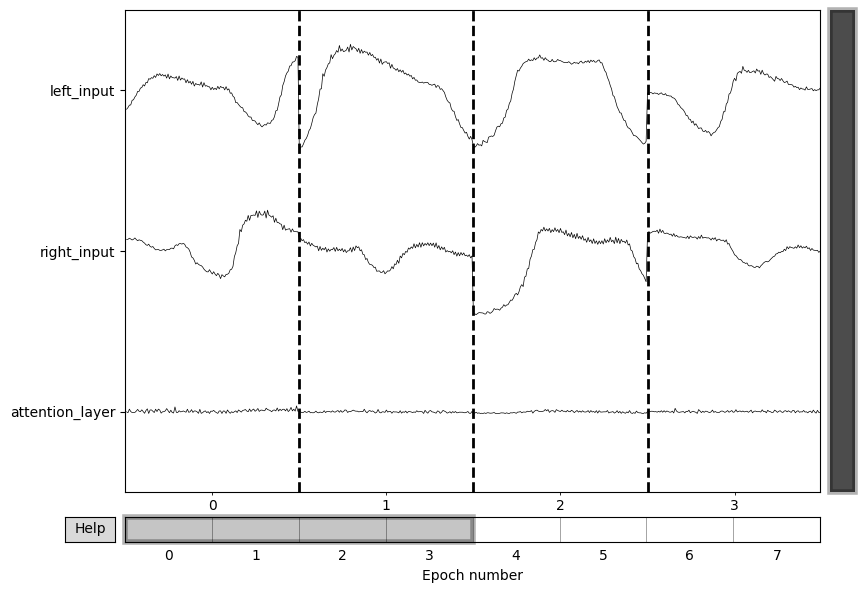

raw_data_left shape = (18, 250)
raw data left reshaped = (3, 1500)
raw_data_left = <RawArray | 3 x 1500 (3.0 s), ~42 kB, data loaded>
[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]]
raw_data_left shape = (33, 250)
raw data left reshaped = (3, 2750)
raw_data_left = <RawArray | 3 x 2750 (5.5 s), ~72 kB, data loaded>
[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]
 [1500    0    1]
 [1750    0    1]
 [2000    0    1]
 [2250    0    1]
 [2500    0    1]]
raw_data_left shape = (30, 250)
raw data left reshaped = (3, 2500)
raw_data_left = <RawArray | 3 x 2500 (5.0 s), ~66 kB, data loaded>
[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]
 [1500    0    1]
 [1750    0    1]
 [2000    0    1]
 [2250    0    1]]
raw_data_left shape = (36, 250)
raw data left reshaped = (3, 3000)
raw_data_left = <RawArray | 3 x 3000 (6.0 

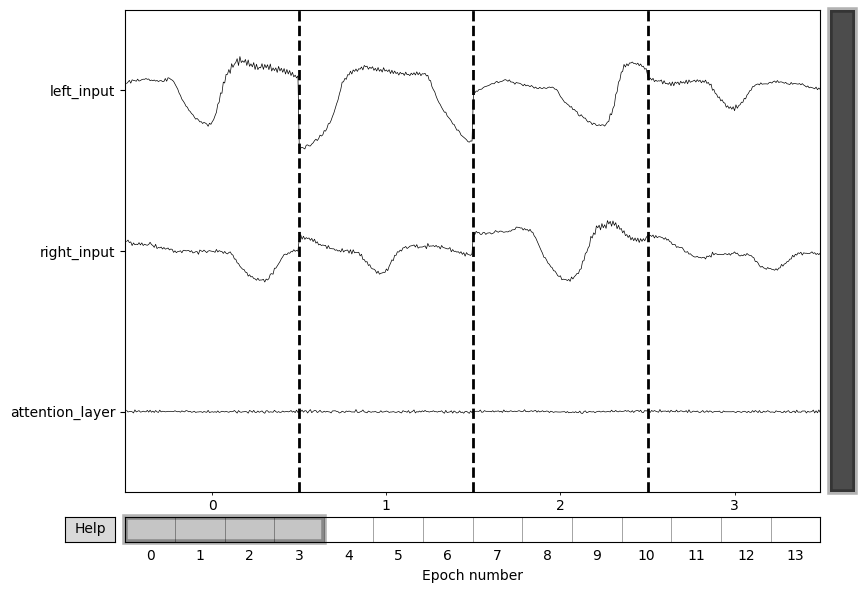

[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]
 [1500    0    1]
 [1750    0    1]
 [2000    0    1]
 [2250    0    1]
 [2500    0    1]
 [2750    0    1]
 [3000    0    1]]
[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]
 [1500    0    1]
 [1750    0    1]
 [2000    0    1]
 [2250    0    1]]
[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]
 [1500    0    1]
 [1750    0    1]]
[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]
 [1500    0    1]
 [1750    0    1]
 [2000    0    1]
 [2250    0    1]
 [2500    0    1]
 [2750    0    1]
 [3000    0    1]]
[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]
 [1500    0    1]
 [1750    0    1]
 [2000    0    1]]
[[   0    0    1]
 [ 250    0    1]
 [ 50

In [4]:
##this will plot unprocessed data and then processed data to see the difference
left, right = 17, 17
#-------------wsmi calculation----------------
n_times = 250
dt = 0.002
sfreq = 1 / dt

ch_names = ['left_input', 'right_input', 'attention_layer']
ch_types = ['eeg', 'eeg', 'eeg']
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

for class_left in classes_left:
    wsmi_start = time.time()
    for class_right in classes_right: 
        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] == 0:
            continue            

        #reshaping data for attention left
        raw_data_left = np.concatenate([
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'], 
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] 
            ], axis=0)

        print("raw_data_left shape =", raw_data_left.shape)  
        #Reshape into (n_channels, n_samples)
        raw_data_left = raw_data_left.reshape(3, -1)  
        print('raw data left reshaped =', raw_data_left.shape) 
        raw_left = mne.io.RawArray(raw_data_left, info)
        print("raw_data_left =", raw_left)



        #defininf event objects, arrays like [0,0,1], [500, 0, 1], [1000, 0, 1] etc
        events_left = np.array([[i * n_times, 0, 1] for i in range(0, n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft']) ])
        print(events_left)

        epochs_left = mne.Epochs(raw_left, events_left, event_id={'Trial': 1}, tmin=0, tmax =  0.25,  baseline=None, preload=True)

        if class_left == left and class_right == right:
            epochs_left.plot(n_epochs = 4, n_channels=3, scalings = 'auto', title="Attention Left")
            plt.show()



for class_left in classes_left:
    wsmi_start = time.time()
    for class_right in classes_right:       
        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] == 0:  
            continue      

        #reshaping date for attention right 
        raw_data_right = np.concatenate([
            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}']            
        ], axis=0)

        #print('raw_data_right shape =', raw_data_right.shape)
        raw_data_right = raw_data_right.reshape(3, -1)
        #print('raw_data_right reshaped =', raw_data_right.shape)
        raw_right = mne.io.RawArray(raw_data_right, info)
        #print('raw_data_right =', raw_right)


        events_right = np.array([[i * n_times, 0, 1] for i in range(0, n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright']) ]) 
        print(events_right)

        epochs_right = mne.Epochs(raw_right, events_right, event_id={'Trial': 1}, tmin=0, tmax = 0.25, baseline=None, preload=True)
        
        if class_left == left and class_right == right:
            epochs_right.plot(n_epochs = 4, n_channels=3, scalings = 'auto', title="Attention Right")
            plt.show()
        
        